# Preprocessing and training

## Import necessary modules

In [1]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os
import ast
import datetime as dt
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]
plt.rcParams['font.size'] = 14
import seaborn as sns
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
start = dt.datetime.now()

## Set path of data. DP_DIR is used for training, which includes shuffling dataset

In [69]:
DP_DIR = 'shuffle_csv/' # set a folder called 'shuffle_csv'
INPUT_DIR = 'data/' # Just put source data into 'data' folder
BASE_SIZE = 256
NCSVS = 100
NCATS = 20
np.random.seed(seed=1987)
tf.set_random_seed(seed=1987)

def f2cat(filename: str) -> str:
    return filename.split('.')[0]

def list_all_categories():
    files = os.listdir(INPUT_DIR)
    return sorted([f2cat(f) for f in files], key=str.lower)

In [70]:
list_all_categories()

['',
 'airplane',
 'ambulance',
 'bicycle',
 'bus',
 'canoe',
 'car',
 'cruise ship',
 'firetruck',
 'helicopter',
 'hot air balloon',
 'motorbike',
 'pickup truck',
 'police car',
 'sailboat',
 'school bus',
 'speedboat',
 'submarine',
 'train',
 'truck']

## Functions for evaluating

In [16]:
def apk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    if len(predicted) > k:
        predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0
    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)
    if not actual:
        return 0.0
    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    """
    Source: https://github.com/benhamner/Metrics/blob/master/Python/ml_metrics/average_precision.py
    """
    return np.mean([apk(a, p, k) for a, p in zip(actual, predicted)])

def preds2catids(predictions):
    return pd.DataFrame(np.argsort(-predictions, axis=1)[:, :3], columns=['a', 'b', 'c'])

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

## Set training parameters

In [17]:
STEPS = 800
EPOCHS = 16
size = 64
batchsize = 680

## Construct model

In [71]:
model = MobileNet(input_shape=(size, size, 1), alpha=1., weights=None, classes=NCATS)
model.compile(optimizer=Adam(lr=0.002), loss='categorical_crossentropy',
              metrics=[categorical_crossentropy, categorical_accuracy, top_3_accuracy])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 66, 66, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 32, 32, 32)        288       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 32, 32, 32)        128       
_________________________________________________________________
conv1_relu (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 34, 34, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 32, 32, 32)        288       
__________

## Transform csv data into 2D grayscale image

In [98]:
def draw_cv2(raw_strokes, size=256, lw=6, time_color=True):
    img = np.zeros((BASE_SIZE, BASE_SIZE), np.uint8)
    for t, stroke in enumerate(raw_strokes):
        for i in range(len(stroke[0]) - 1):
            color = 255 - min(t, 10) * 13 if time_color else 255
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]),
                         (stroke[0][i + 1], stroke[1][i + 1]), color, lw)
    if size != BASE_SIZE:
        return cv2.resize(img, (size, size))
    else:
        return img

def image_generator_xd(size, batchsize, lw=6, time_color=True):

    df_list = []
    path = DP_DIR
    for file in os.listdir(path):  
        file_path = os.path.join(path, file)  
        df_file = pd.read_csv(file_path, skiprows=lambda x: 0<x<100)
        df_list.append(df_file)
    df_train = df_list[0]
    for i in range(1, len(df_list)):
        df_train = pd.concat((df_train, df_list[i]), axis = 0)
    df_train.reset_index(drop = True)
    df_train = shuffle(df_train)
    df_train.reset_index(drop = True)
    df_train['word'] = df_train['word'].map(dic)
    df_train.to_csv('final_train.csv')
    for df in pd.read_csv('final_train.csv', chunksize = batchsize):
        df['drawing'] = df['drawing'].apply(ast.literal_eval)
        x = np.zeros((len(df), size, size, 1))
        for i, raw_strokes in enumerate(df.drawing.values):
            x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
                                             time_color=time_color)
        x = preprocess_input(x).astype(np.float32)
        y = keras.utils.to_categorical(df.word, num_classes=NCATS)
        yield x, y


#         for k in np.random.permutation(ks):
#             filename = os.path.join(DP_DIR, 'train_k{}.csv.gz'.format(k))
#             for df in pd.read_csv(filename, chunksize=batchsize):
#                 df['drawing'] = df['drawing'].apply(ast.literal_eval)
#                 x = np.zeros((len(df), size, size, 1))
#                 for i, raw_strokes in enumerate(df.drawing.values):
#                     x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw,
#                                              time_color=time_color)
#                 x = preprocess_input(x).astype(np.float32)
#                 y = keras.utils.to_categorical(df.y, num_classes=NCATS)
#                 yield x, y

def df_to_image_array_xd(df, size, lw=6, time_color=True):
#     df['drawing'] = df['drawing'].apply(ast.literal_eval)
    x = np.zeros((len(df), size, size, 1))
    for i, raw_strokes in enumerate(df.drawing.values):
        x[i, :, :, 0] = draw_cv2(raw_strokes, size=size, lw=lw, time_color=time_color)
    x = preprocess_input(x).astype(np.float32)
    return x

## Generate shuffling dataset

In [24]:
from sklearn.utils import shuffle
path = INPUT_DIR
for file in os.listdir(path):  
        file_path = os.path.join(path, file)  
        df = pd.read_csv(file_path)
        df = shuffle(df)
        target_path = DP_DIR + file
        df.to_csv(target_path)

## Generate validation dataset for training

In [26]:
def generate_valid(path):
    df_list = []
    for file in os.listdir(path):  
        file_path = os.path.join(path, file)  
        df = pd.read_csv(file_path, nrows = 100)
        df_list.append(df)
    return df_list
df_list = generate_valid(DP_DIR)
valid_df = df_list[0]
for i in range(1, len(df_list)):
    valid_df = pd.concat((valid_df, df_list[i]), axis = 0)

## Transform word label into integers

In [45]:
dic = {}
categories = list_all_categories()
for i in range(len(categories)):
    dic[categories[i]] = i

In [51]:
valid_df['word'] = valid_df['word'].map(dic)

In [57]:
valid_df = valid_df.reset_index(drop = True)

In [73]:
x_valid = df_to_image_array_xd(valid_df, size)
y_valid = keras.utils.to_categorical(valid_df.word, num_classes=NCATS)
print(x_valid.shape, y_valid.shape)
print('Validation array memory {:.2f} GB'.format(x_valid.nbytes / 1024.**3 ))

(1900, 64, 64, 1) (1900, 20)
Validation array memory 0.03 GB


## Generate training set

In [99]:
train_datagen = image_generator_xd(size=size, batchsize=batchsize)

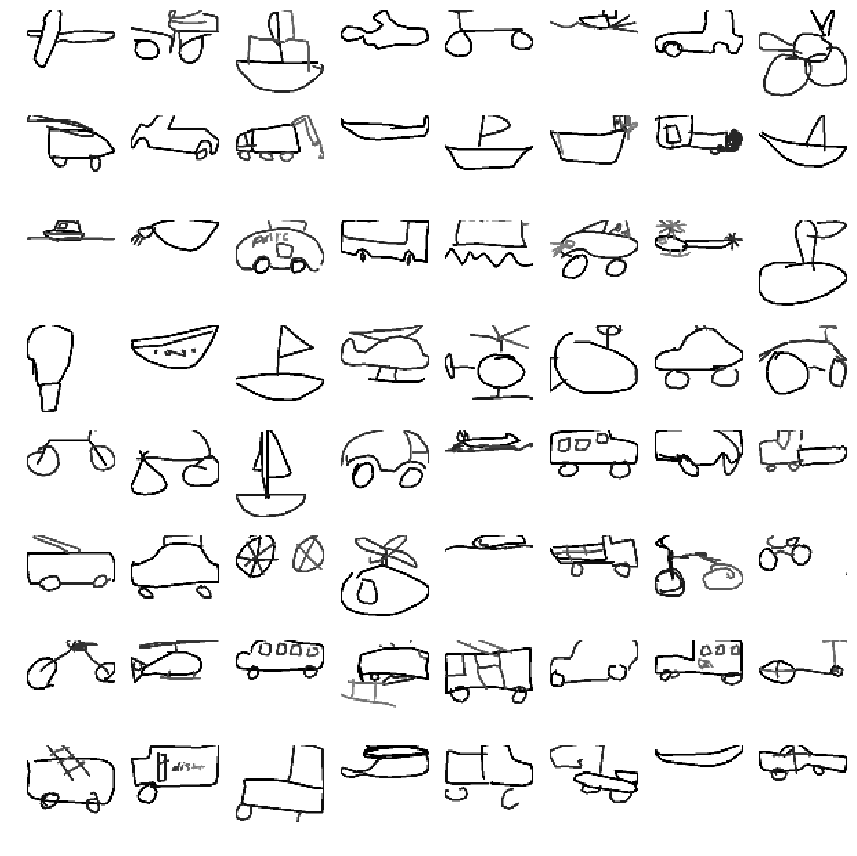

In [100]:
x, y = next(train_datagen)
n = 8
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
for i in range(n**2):
    ax = axs[i // n, i % n]
    (-x[i]+1)/2
    ax.imshow((-x[i, :, :, 0] + 1)/2, cmap=plt.cm.gray)
    ax.axis('off')
plt.tight_layout()
fig.savefig('gs.png', dpi=300)
plt.show();

## Start training

In [ ]:
callbacks = [
    ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=5,
                      min_delta=0.005, mode='max', cooldown=3, verbose=1)
]
hists = []
hist = model.fit_generator(
    train_datagen, steps_per_epoch=STEPS, epochs=EPOCHS, verbose=1,
    validation_data=(x_valid, y_valid),
    callbacks = callbacks
)
hists.append(hist)

## Training analysis

In [ ]:
hist_df = pd.concat([pd.DataFrame(hist.history) for hist in hists], sort=True)
hist_df.index = np.arange(1, len(hist_df)+1)
fig, axs = plt.subplots(nrows=2, sharex=True, figsize=(16, 10))
axs[0].plot(hist_df.val_categorical_accuracy, lw=5, label='Validation Accuracy')
axs[0].plot(hist_df.categorical_accuracy, lw=5, label='Training Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].grid()
axs[0].legend(loc=0)
axs[1].plot(hist_df.val_categorical_crossentropy, lw=5, label='Validation MLogLoss')
axs[1].plot(hist_df.categorical_crossentropy, lw=5, label='Training MLogLoss')
axs[1].set_ylabel('MLogLoss')
axs[1].set_xlabel('Epoch')
axs[1].grid()
axs[1].legend(loc=0)
fig.savefig('hist.png', dpi=300)
plt.show();

## Make predictions

In [ ]:
valid_predictions = model.predict(x_valid, batch_size=128, verbose=1)
map3 = mapk(valid_df[['y']].values, preds2catids(valid_predictions).values)
print('Map3: {:.3f}'.format(map3))